In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from matplotlib.colors import ListedColormap

from finetune.segment.chesapeake_datamodule import ChesapeakeDataModule
from finetune.segment.chesapeake_model import ChesapeakeSegmentor

### Define paths and parameters

In [3]:
CHESAPEAKE_CHECKPOINT_PATH = (
    "../../checkpoints/segment/deepglobe-roads-segment_epoch-00_val-iou-0.9242.ckpt"
)
CLAY_CHECKPOINT_PATH = "../../checkpoints/clay-v1-base.ckpt"
METADATA_PATH = "../../configs/metadata.yaml"

DEEPGLOBE_DIR = "/Users/swatts/repos/research_nbs/st3-262-road-width-satellite-data/data/deepglobe/"
TRAIN_CHIP_DIR = DEEPGLOBE_DIR + "train_crops/images/"
TRAIN_LABEL_DIR = DEEPGLOBE_DIR + "train_crops/gt/"
VAL_CHIP_DIR = DEEPGLOBE_DIR + "val_crops/images/"
VAL_LABEL_DIR = DEEPGLOBE_DIR + "val_crops/gt/"

BATCH_SIZE = 4
NUM_WORKERS = 0
PLATFORM = "deepglobe-roads"
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

### Model Loading

In [4]:
def get_model(chesapeake_checkpoint_path, clay_checkpoint_path, metadata_path):
    model = ChesapeakeSegmentor.load_from_checkpoint(
        checkpoint_path=chesapeake_checkpoint_path,
        metadata_path=metadata_path,
        ckpt_path=clay_checkpoint_path,
    )
    model = model.to(DEVICE)
    model.eval()
    return model

### Data Preparation

In [5]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
):
    dm = ChesapeakeDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
    )
    dm.setup(stage="fit")
    val_dl = iter(dm.val_dataloader(True))
    batch = next(val_dl)
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [6]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(512, 512), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [7]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means).reshape(1, -1, 1, 1)
    stds = np.array(stds).reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means
    return denormalized_images.astype(np.uint8)  # Do for NAIP/LINZ


def post_process(batch, outputs, metadata):
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    means = list(metadata[PLATFORM].bands.mean.values())
    stds = list(metadata[PLATFORM].bands.std.values())
    # norm_pixels = denormalize_images(pixels, means, stds)

    images = rearrange(pixels[:, :3, :, :], "b c h w -> b h w c")

    return images, labels, preds

### Plotting

In [8]:
def plot_predictions(images, labels, preds):
    fig, axes = plt.subplots(3, BATCH_SIZE)

    # Plot the images
    plot_data(axes, images, row_offset=0, title="Image")

    # Plot the actual segmentation maps
    plot_data(axes, labels, row_offset=1, title="Actual", cmap="viridis")

    # Plot the predicted segmentation maps
    plot_data(axes, preds, row_offset=2, title="Pred", cmap="viridis")

    plt.tight_layout()
    plt.show()


def plot_data(ax, data, row_offset, title=None, cmap=None, vmin=None, vmax=None):
    for i, item in enumerate(data):
        row = row_offset + (i // 8) * 3
        col = i % 8
        ax[row, col].imshow(item, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[row, col].axis("off")
        if title and col == 0:
            ax[row, col].set_title(title, rotation=0, fontsize=12)

In [9]:
# Load model
model = get_model(CHESAPEAKE_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)

In [10]:
# Get data
batch, metadata = get_data(
    TRAIN_CHIP_DIR,
    TRAIN_LABEL_DIR,
    VAL_CHIP_DIR,
    VAL_LABEL_DIR,
    METADATA_PATH,
    BATCH_SIZE,
    NUM_WORKERS,
    PLATFORM,
)
# Move batch to GPU
batch = {k: v.to(DEVICE) for k, v in batch.items()}

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [23]:
# Run prediction
outputs = run_prediction(model, batch)

In [28]:
# Post-process the results
images, labels, preds = post_process(batch, outputs, metadata)

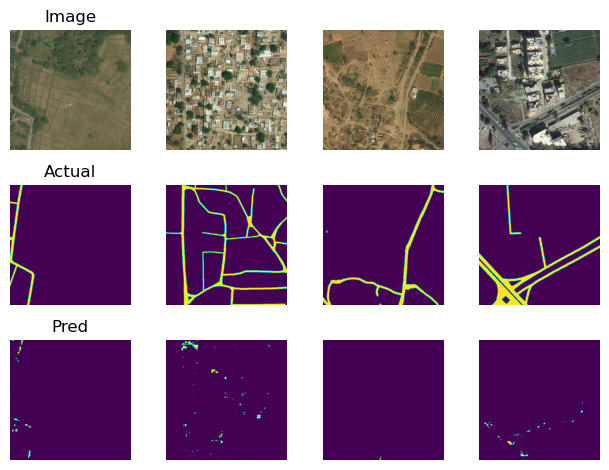

In [30]:
# Plot the predictions
plot_predictions(images, labels, preds)

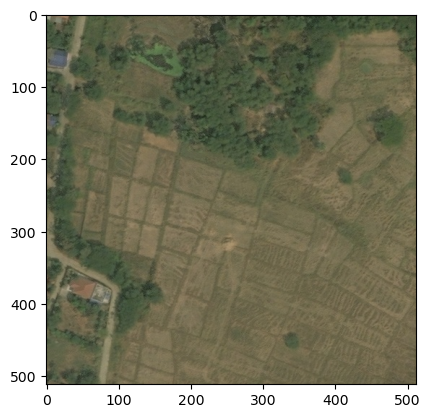

In [29]:
plt.imshow(images[0])